In [1]:
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np


In [2]:
dialogs_info = {
    "Private dialog": {},
    "Group": {},
    "Channel": {}
                }

# set paths to dirs in data dir
temp_dir = os.getcwd()
os.chdir("..")
path_data_dir = os.path.join(os.getcwd(), "data")
path_dialogs_meta_dir = os.path.join(path_data_dir, "dialogs_meta")
path_dialogs_dir = os.path.join(path_data_dir, "dialogs")
os.chdir(temp_dir)

# make dialogs_info dict: first level keys - "Channel", "Private dialog", "Group"
# second level items - "<name_of_dialog>": <id>
for file in os.listdir(path_dialogs_meta_dir):
    if file[-4:] == "json":
        with open(os.path.join(path_dialogs_meta_dir, file), "r", encoding="utf8") as meta_file:
            data = json.load(meta_file)

        dialogs_info[data["type"]][data["name"]] = data["id"]

# 1) look at results in ../static/dialogs_info.json
with open("../static/dialogs_info.json", "w", encoding="utf-8") as f:
    json.dump(dialogs_info, f, indent=4, ensure_ascii=False)

## Plot of daily activity (09.08.2020)

In [3]:
def get_user_activity(dialogs_info, date_before, date_after, dialog_type,
                      plot_type="daily_activity"):
    """

    :param dialogs_info: dict: first level keys - "Channel", "Private dialog", "Group"
    second level items - "<name_of_dialog>": <id>
    :param date_before: datetime type, from what time start to analyse msgs
    :param date_after: datetime type, to what time to analyse msgs
    :param dialog_type: "Channel" or "Private dialog" or "Group"
    :param plot_type: plot name for which you prepare your data
    :return: lists for a plot of "top_friends" or "daily_activity", depends on
    your input plot_type
    """
    dialog_active_minutes = 0

    plot_data = {}
    if plot_type == "daily_activity":
        for hour in range(24):
            if hour < 10:
                hour = '0' + str(hour)
                plot_data[hour] = 0
            else:
                plot_data[str(hour)] = 0

    # go through all dialogs on special dialog type in dialogs_info dict
    # friend - name of dialog
    for friend, dialog_id in dialogs_info[dialog_type].items():
        dialog_id = str(dialog_id)
        start_dialog_time, stop_dialog_time = 0, 0
        if dialog_id + ".csv" not in os.listdir(path_dialogs_dir):
            print(dialog_id)
            continue

        dialog_data = pd.read_csv("../data/dialogs/{}.csv".format(dialog_id))
        dialog_active_minutes_before = dialog_active_minutes
        flag_first_my_message = 0
        for row in dialog_data.index:
            if dialog_data["from_id"][row] == 511986933:

                date_time = dialog_data["date"][row][:-6]
                dialog_datetime = datetime.datetime.strptime(date_time,"%Y-%m-%d %H:%M:%S")
                
                # get previous message time for plot of "active_minutes" - number of minutes spending on
                # conversations during a day
                if flag_first_my_message == 0:
                    previous_message_time = dialog_datetime
                    flag_first_my_message = 1

                if dialog_datetime <= date_before:
                    break

                elif date_before < dialog_datetime < date_after:
                    if plot_type == "daily_activity":
                        our_local_time = int(dialog_data['date'][row][11:13]) + 2
                        if our_local_time < 10:
                            our_local_time = "0" + str(our_local_time)
                            
                        else:
                            our_local_time = str(our_local_time)
                                
                        plot_data[our_local_time] += 1

                    elif plot_type == "top_friends":
                        plot_data[friend] = plot_data.get(friend, 0) + 1

                    elif plot_type == "active_minutes":
                        time_before_my_messages = previous_message_time - dialog_datetime
                        try:
                            if dialog_data["from_id"][row + 1] == 511986933 and \
                                    time_before_my_messages.total_seconds() < 600:
                                previous_message_time = dialog_datetime
                                if stop_dialog_time == 0:
                                    stop_dialog_time = dialog_datetime

                            else:
                                if stop_dialog_time == 0:
                                    dialog_active_minutes += 15
                                else:
                                    start_dialog_time = dialog_datetime
                                    time_since = stop_dialog_time - start_dialog_time
                                    if time_since.total_seconds() >= 600:
                                        time_since = stop_dialog_time - previous_message_time
                                        dialog_active_minutes += time_since.total_seconds() + 40 + 30

                                    else:
                                        # add 40 sec - time for reading, writing first message
                                        dialog_active_minutes += time_since.total_seconds() + 40

                                previous_message_time = dialog_datetime
                                start_dialog_time, stop_dialog_time = 0, 0

                        except KeyError as error:
                            print("KEYERROR!!!", error)

        if plot_type == "active_minutes":
            print("Time spend on conversation: dialog {} {} minutes".format(friend,
                                                                            (dialog_active_minutes - dialog_active_minutes_before) // 60))

    if plot_type == "active_minutes":
        # add 5 minutes in case of unpredictable situations
        return dialog_active_minutes // 60 + 5

    x, y = "", ""
    lists = []
    if plot_type == "daily_activity":
        lists = sorted(plot_data.items())
        x, y = zip(*lists)
    elif plot_type == "top_friends":
        lists = {k: v for k, v in sorted(plot_data.items(), key=lambda item: item[1], reverse=True)}

    return x, y, lists

777000
777000
777000
777000
777000
777000
777000


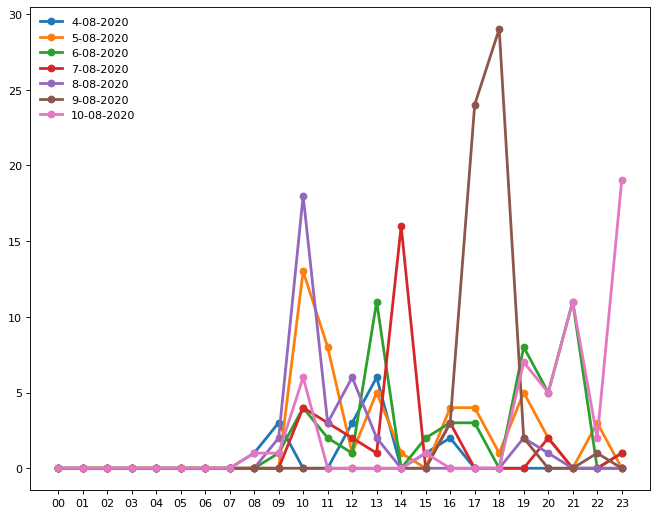

In [10]:
from matplotlib.pyplot import figure
import plotly.graph_objects as go

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
fig = go.Figure()

for i in range(7):
    date_before = datetime.datetime(2020, 8, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Private dialog")

    fig.add_trace(go.Bar(
        y=x,
        x=y,
        name="{}-08-2020".format(4 + i),
        orientation='h',
        marker=dict(
            line=dict(color='rgb(105, 105, 105, 1.0)', width=3)
        )
    ))
    plt.plot(x, y, linewidth=2.5, marker='o', linestyle="-", label="{}-08-2020".format(4 + i))

plt.xticks([i for i in range(0, 24)])
plt.legend(loc='upper left', frameon=False)
plt.show()

# show comparing bar
fig.update_layout(
    barmode='stack',
    autosize=False,
    width=800,
    height=800,
    yaxis = dict(
            title='Hours',
            titlefont_size=16,
            tickfont_size=14,
            tickmode = 'array',
            tickvals = [i for i in range(24)]),
    xaxis = dict(
            title='Number of messages',
            titlefont_size=16,
            tickfont_size=14)
)
fig.show()

## Top people with whom communicate during 10.06.2020 - 09.08.2020

In [7]:
date_before = datetime.datetime(2020, 6, 10, 0, 0, 0)
date_after = datetime.datetime(2020, 8, 10, 0, 0, 0)
x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", "top_friends")
for place, friend in enumerate(lists.items()):
    print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))

777000
1 place is Діма Лопушанський with 508 messages
2 place is Назар Поночевний with 470 messages
3 place is Паша Уку Астроном with 365 messages
4 place is Добосевич Олесь with 350 messages
5 place is Denys Herasymuk with 297 messages
6 place is Gleb Plakhtiy with 207 messages
7 place is Христина БА with 49 messages
8 place is Володя Савчук with 21 messages


## Top groups with whom communicate during 10.06.2020 - 09.08.2020

In [8]:
x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Group", "top_friends")
for place, friend in enumerate(lists.items()):
    print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))

1 place is d2v with 77 messages
2 place is ПОК Проект with 9 messages
3 place is 🤪Будущі бомжі (4K)🥴 with 7 messages
4 place is APPS@UCU (всі) ❤️ with 1 messages


## Time spending on conversations during 03.08.2020 - 09.08.2020

Time spend on conversation: dialog Діма Лопушанський 1.0 minutes
Time spend on conversation: dialog Володя Савчук 0.0 minutes
Time spend on conversation: dialog Добосевич Олесь 0.0 minutes
Time spend on conversation: dialog Назар Поночевний 1.0 minutes
Time spend on conversation: dialog Gleb Plakhtiy 0.0 minutes
Time spend on conversation: dialog Паша Уку Астроном 0.0 minutes
Time spend on conversation: dialog Denys Herasymuk 0.0 minutes
Time spend on conversation: dialog Христина БА 1.0 minutes
777000
Time spend on conversation: dialog BookCrossing - Обмен книгами 0 minutes
Time spend on conversation: dialog React Kyiv 0 minutes
Time spend on conversation: dialog Arch Linux RU 0 minutes
Time spend on conversation: dialog УКУ Рандом | REBOOTED 0 minutes
Time spend on conversation: dialog APPS@UCU (всі) ❤️ 0 minutes
Time spend on conversation: dialog sns_internships 0 minutes
Time spend on conversation: dialog ПОК Проект 0 minutes
Time spend on conversation: dialog 🤪Будущі бомжі (4K)🥴 0

<Figure size 1280x1120 with 0 Axes>

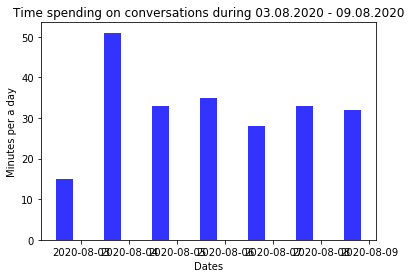

In [23]:
plot_data = {}
for i in range(7):
    date_before = datetime.datetime(2020, 8, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    general_dialog_time = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", "active_minutes") \
                          + get_user_activity(dialogs_info, date_before, date_after, "Group", "active_minutes")
    plot_data[datetime.date(2020, 8, 3 + i)] = general_dialog_time

print(plot_data)
lists = sorted(plot_data.items())
dates, n_minutes_lst = zip(*lists)

n_days = 7

# create plot
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots()
index = np.arange(n_days)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, n_minutes_lst, bar_width,
alpha=opacity,
color='b')

plt.xlabel('Dates')
plt.ylabel('Minutes per a day')
plt.title('Time spending on conversations during 03.08.2020 - 09.08.2020')
plt.xticks(index + bar_width, dates)

plt.show()

AttributeError: 'tuple' object has no attribute 'add'